In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [10]:
Data = pd.read_csv('/content/QVI_data.csv')

In [11]:
Data.head(2)

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream


In [12]:
Data['DATE'] = pd.to_datetime(Data['DATE'])
Data['YEARMONTH'] = Data['DATE'].dt.strftime('%Y%m')
Data["MONTH_ID"] = Data["DATE"].dt.strftime("%Y%m").astype("int")

In [13]:
Data.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,YEARMONTH,MONTH_ID
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium,201810,201810
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream,201809,201809
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget,201903,201903
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget,201903,201903
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream,201811,201811


We would want to match trial stores to control stores that are similar to the trial
store prior to the trial period of Feb 2019 in terms of :
- Monthly overall sales revenue
- Monthly number of customers
- Monthly number of transactions per customer




In [14]:
# Monthly total sales
M_TOT_SALES = Data.groupby(["STORE_NBR","MONTH_ID"])["TOT_SALES"].sum()

# Monthly customer counts
M_CUS_COUNTS = Data.groupby(["STORE_NBR","MONTH_ID"])["LYLTY_CARD_NBR"].nunique()

# Monthly transactions per customer
M_TXN_CUS = Data.groupby(["STORE_NBR","MONTH_ID"])["TXN_ID"].nunique()/M_CUS_COUNTS

# Monthly chips per customer
M_CHIP_CUS = Data.groupby(["STORE_NBR","MONTH_ID"])["PROD_QTY"].sum()/M_CUS_COUNTS

# Monthly average price per unit
M_AVG_PRICE_CHIP = M_TOT_SALES/Data.groupby(["STORE_NBR","MONTH_ID"])["PROD_QTY"].sum()

# Combining metrics together
measure_over_time = pd.concat([M_TOT_SALES, M_CUS_COUNTS, M_TXN_CUS, M_CHIP_CUS, M_AVG_PRICE_CHIP],axis=1)
measure_over_time.columns = ["totSales", "nCustomers", "nTxnPerCust", "nChipsPerTxn", "avgPricePerUnit"]
measure_over_time = measure_over_time.reset_index()
measure_over_time.head()

,STORE_NBR,MONTH_ID,totSales,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit
0,1,201807,206.9,49,1.061224,1.265306,3.337097
1,1,201808,176.1,42,1.023810,1.285714,3.261111
2,1,201809,278.8,59,1.050847,1.271186,3.717333
3,1,201810,188.1,44,1.022727,1.318182,3.243103
4,1,201811,192.6,46,1.021739,1.239130,3.378947


In [15]:
# Stores with full observation periods(12 month)
obs_counts = measure_over_time["STORE_NBR"].value_counts()
full_idx = obs_counts[obs_counts == 12].index
storesWithFullObs = measure_over_time[measure_over_time["STORE_NBR"].isin(full_idx)]

# Filter to the pre-trial period (201807 - 201901)
preTrialMeasures = storesWithFullObs[storesWithFullObs["MONTH_ID"] < 201902]
preTrialMeasures.head()

,STORE_NBR,MONTH_ID,totSales,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit
0,1,201807,206.9,49,1.061224,1.265306,3.337097
1,1,201808,176.1,42,1.023810,1.285714,3.261111
2,1,201809,278.8,59,1.050847,1.271186,3.717333
3,1,201810,188.1,44,1.022727,1.318182,3.243103
4,1,201811,192.6,46,1.021739,1.239130,3.378947


In [16]:
def calculateCorrelation(inputTable, metricCol, storeComparison):

    control_all = inputTable.loc[~inputTable["STORE_NBR"].isin([77,86,88])]
    trial = inputTable.loc[inputTable["STORE_NBR"] == storeComparison][metricCol].reset_index()
    calcCorrTable = pd.DataFrame(columns = ["Control_Store", "Trial_Store", "Corr"])

    for i in control_all["STORE_NBR"].unique():
        control = control_all[control_all["STORE_NBR"]==i][metricCol].reset_index()
        correlation = control.corrwith(trial,axis=0)[1]
        calcCorrTable_i = pd.DataFrame({"Control_Store":i,"Trial_Store":storeComparison,"Corr":[correlation]})
        calcCorrTable = pd.concat([calcCorrTable, calcCorrTable_i])

    return calcCorrTable

In [18]:
def calculateMagnitudeDistance(inputTable, metricCol, storeComparison):


    control_all = inputTable.loc[~inputTable["STORE_NBR"].isin([77,86,88])]
    trial = inputTable.loc[inputTable["STORE_NBR"] == storeComparison].reset_index()[metricCol]
    calcDistTable = pd.DataFrame(columns=["Control_Store", "Trial_Store", "Magnitude"])

    for i in control_all["STORE_NBR"].unique():
        control = control_all[control_all["STORE_NBR"]==i].reset_index()[metricCol]
        diff = abs(trial - control)
        # Standardise the magnitude distance so that the measure ranges from 0 to 1
        s_diff = np.mean(1-((diff-min(diff))/(max(diff)-min(diff))))
        calcDistTable_i = pd.DataFrame({"Control_Store":i,"Trial_Store":[storeComparison],"Magnitude": s_diff})
        calcDistTable = pd.concat([calcDistTable, calcDistTable_i])
    return calcDistTable

In [19]:
# calculate correlations against store 77 using total sales and number of customers
# total sales - corr
corr_nSales_77 = calculateCorrelation(preTrialMeasures,"totSales",77)

# total sales - magnitude distance
magnitude_nSales_77 = calculateMagnitudeDistance(preTrialMeasures,"totSales",77)

# number of customers - corr
corr_nCustomers_77 = calculateCorrelation(preTrialMeasures,"nCustomers",77)

# number of customers - magnitude distance
magnitude_nCustomers_77 = calculateMagnitudeDistance(preTrialMeasures,"nCustomers",77)

In [20]:
# Create a combined score composed of correlation and magnitude
# Merging the correlations table with the magnitude table - Total sales
nSales_77_merge = pd.concat([corr_nSales_77,magnitude_nSales_77["Magnitude"]],axis=1)

# Calculate a combined score - Total sales
corr_weight_a = 0.5
nSales_77_merge["score_nSales"] = corr_weight_a * nSales_77_merge["Corr"] + (1-corr_weight_a) * nSales_77_merge["Magnitude"]
nSales_77_merge.head()

,Control_Store,Trial_Store,Corr,Magnitude,score_nSales
0,1,77,0.075218,0.408163,0.241691
0,2,77,-0.263079,0.590119,0.163520
0,3,77,0.806644,0.522914,0.664779
0,4,77,-0.263300,0.644934,0.190817
0,5,77,-0.110652,0.516320,0.202834


In [21]:
# Merging the correlations table with the magnitude table - number of Customers
nCustomers_77_merge = pd.concat([corr_nCustomers_77,magnitude_nCustomers_77["Magnitude"]],axis=1)

# Calculate a combined score - number of Customers
corr_weight_b = 0.5
nCustomers_77_merge["score_nCustomers"] = corr_weight_b * nCustomers_77_merge["Corr"] + (1-corr_weight_b) * nCustomers_77_merge["Magnitude"]
nCustomers_77_merge.head()

,Control_Store,Trial_Store,Corr,Magnitude,score_nCustomers
0,1,77,0.322168,0.663866,0.493017
0,2,77,-0.572051,0.471429,-0.050311
0,3,77,0.834207,0.489796,0.662002
0,4,77,-0.295639,0.498258,0.101310
0,5,77,0.370659,0.512605,0.441632


In [ ]:
# Merging the score tables
finalControlScore_77 = pd.concat([nSales_77_merge[["Control_Store", "Trial_Store", "score_nSales"]],nCustomers_77_merge["score_nCustomers"]],axis=1)

# Calculate a final score
corr_weight_c = 0.5
finalControlScore_77["finalControlScore"] = corr_weight_c * finalControlScore_77["score_nSales"] + (1-corr_weight_c) * finalControlScore_77["score_nCustomers"]
finalControlScore_77.head()

In [23]:
finalControlScore_77.sort_values(by="finalControlScore",ascending=False).head()

,Control_Store,Trial_Store,score_nSales,score_nCustomers,finalControlScore
0,233,77,0.697290,0.816607,0.756949
0,71,77,0.789497,0.663123,0.726310
0,84,77,0.656972,0.715000,0.685986
0,119,77,0.636046,0.729729,0.682887
0,115,77,0.708347,0.645155,0.676751


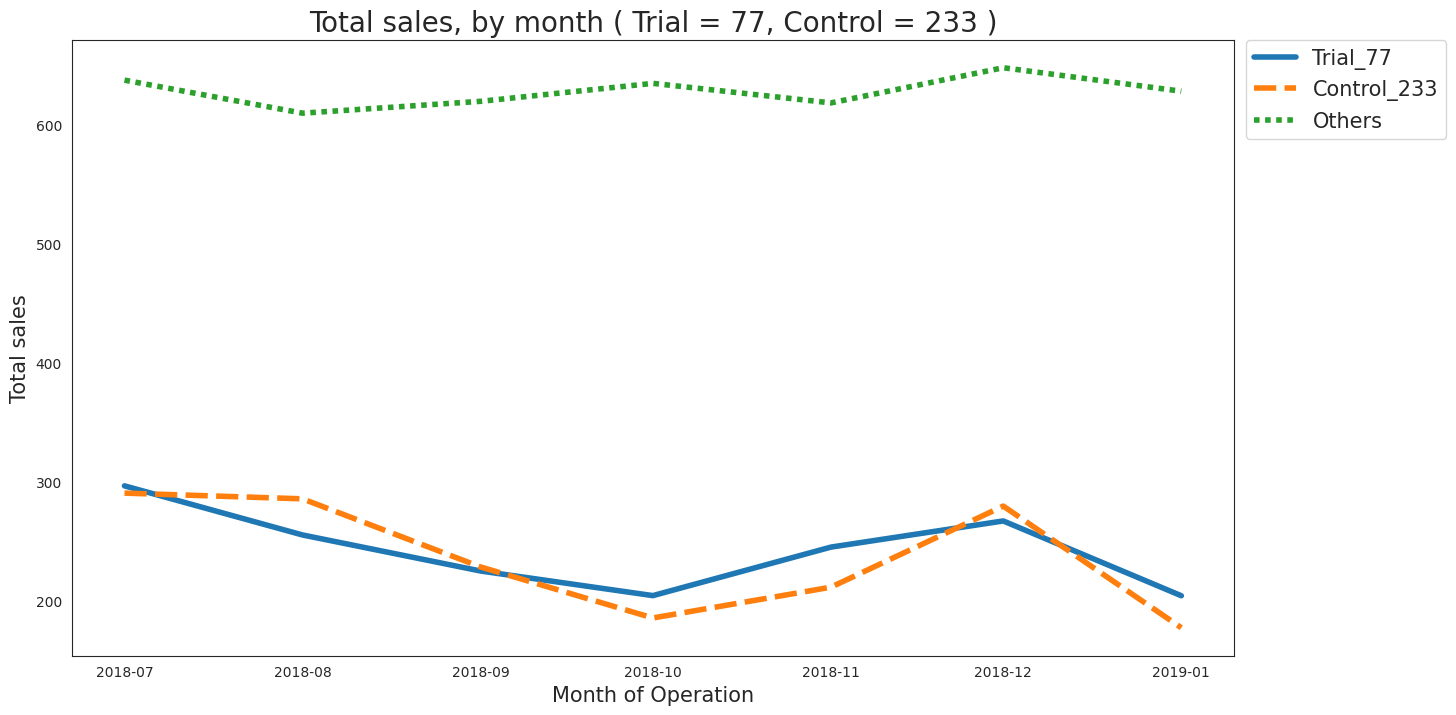

In [24]:
# Visual checks on trends based on the drivers - total sales
a = preTrialMeasures.set_index(["MONTH_ID","STORE_NBR"])["totSales"].unstack()
others_col = [i for i in a.columns if i not in [77, 233]]
a["others"]=a.loc[:,others_col].mean(axis=1)
paired_77_s = a.loc[:,([77,233,"others"])].reset_index()
paired_77_s["MONTH_ID"]= pd.to_datetime(paired_77_s["MONTH_ID"], format="%Y%m")
paired_77_s = paired_77_s.set_index(["MONTH_ID"])
paired_77_s.columns=["Trial_77","Control_233","Others"]

# Create a lineplot
sns.set_style('white')
plt.figure(figsize=(15,8))
plt.title("Total sales, by month ( Trial = 77, Control = 233 )",fontsize=20)
sns.lineplot(data=paired_77_s, linewidth=4)
plt.xlabel("Month of Operation",fontsize=15)
plt.ylabel("Total sales",fontsize=15)
plt.legend(fontsize=15, bbox_to_anchor=(1.01,1),borderaxespad = 0.)

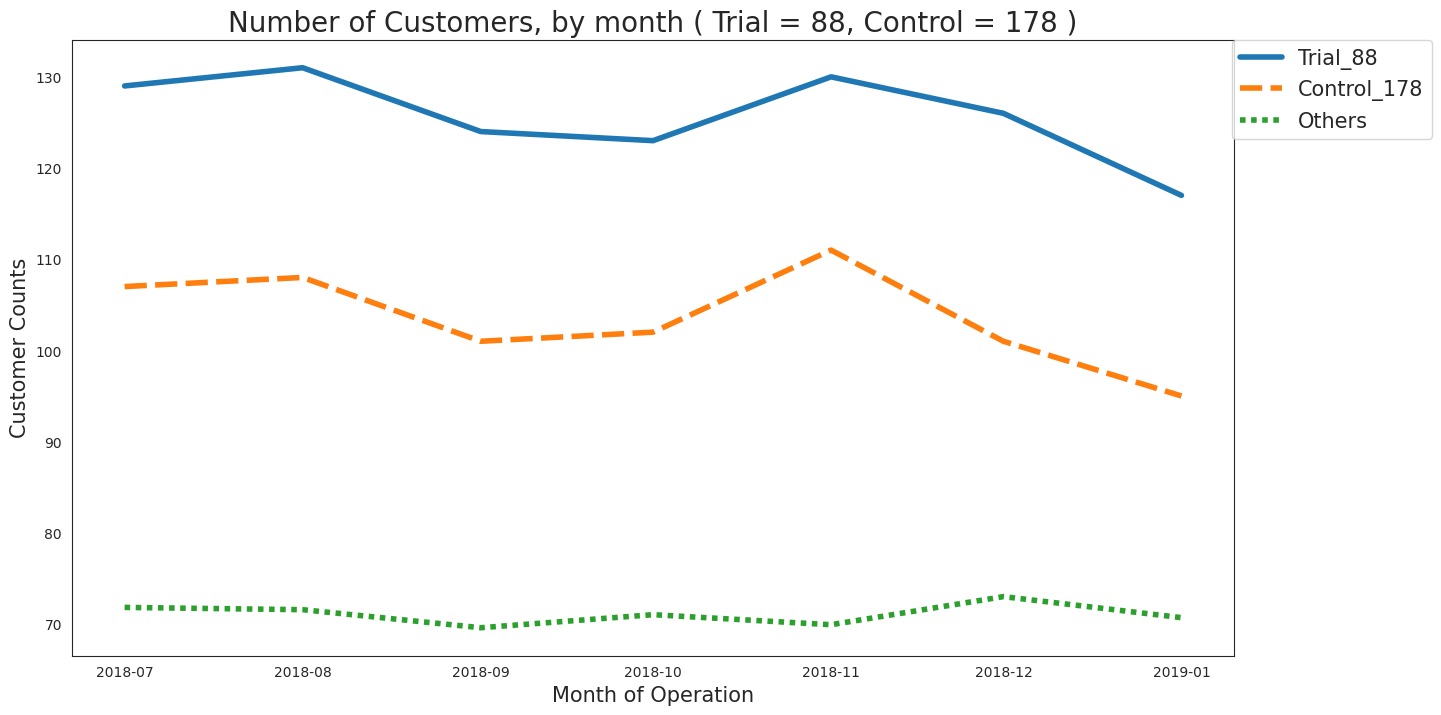

In [25]:
# Visual checks on trends based on the drivers - number of customers
b = preTrialMeasures.set_index(["MONTH_ID","STORE_NBR"])["nCustomers"].unstack()
others_col = [i for i in b.columns if i not in [88, 178]]
b["others"]=b.loc[:,others_col].mean(axis=1)
paired_88_c = b.loc[:,([88,178,"others"])].reset_index()
paired_88_c["MONTH_ID"]= pd.to_datetime(paired_88_c["MONTH_ID"], format="%Y%m")
paired_88_c = paired_88_c.set_index(["MONTH_ID"])
paired_88_c.columns=["Trial_88","Control_178","Others"]

# Create a lineplot
plt.figure(figsize=(15,8))
plt.title("Number of Customers, by month ( Trial = 88, Control = 178 )",fontsize=20)
sns.lineplot(data=paired_88_c, linewidth=4)
plt.xlabel("Month of Operation",fontsize=15)
plt.ylabel("Customer Counts",fontsize=15)
plt.legend(fontsize=15, bbox_to_anchor=(1.17,1),borderaxespad = 0.)

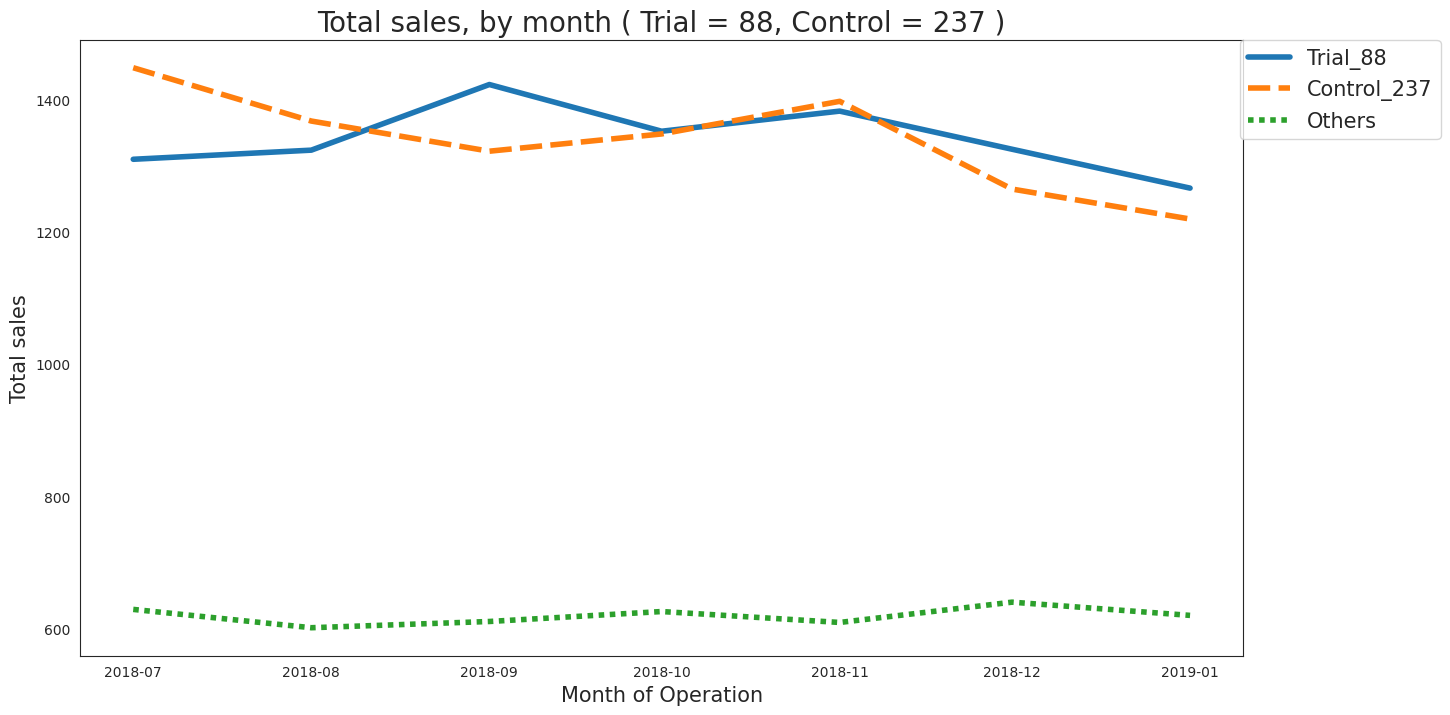

In [26]:
a = preTrialMeasures.set_index(["MONTH_ID","STORE_NBR"])["totSales"].unstack()
others_col = [i for i in a.columns if i not in [88, 237]]
a["others"]=a.loc[:,others_col].mean(axis=1)
paired_88_s = a.loc[:,([88,237,"others"])].reset_index()
paired_88_s["MONTH_ID"]= pd.to_datetime(paired_88_s["MONTH_ID"], format="%Y%m")
paired_88_s = paired_88_s.set_index(["MONTH_ID"])
paired_88_s.columns=["Trial_88","Control_237","Others"]

# Create a lineplot
sns.set_style('white')
plt.figure(figsize=(15,8))
plt.title("Total sales, by month ( Trial = 88, Control = 237 )",fontsize=20)
sns.lineplot(data=paired_88_s, linewidth=4)
plt.xlabel("Month of Operation",fontsize=15)
plt.ylabel("Total sales",fontsize=15)
plt.legend(fontsize=15, bbox_to_anchor=(1.17,1),borderaxespad = 0.)

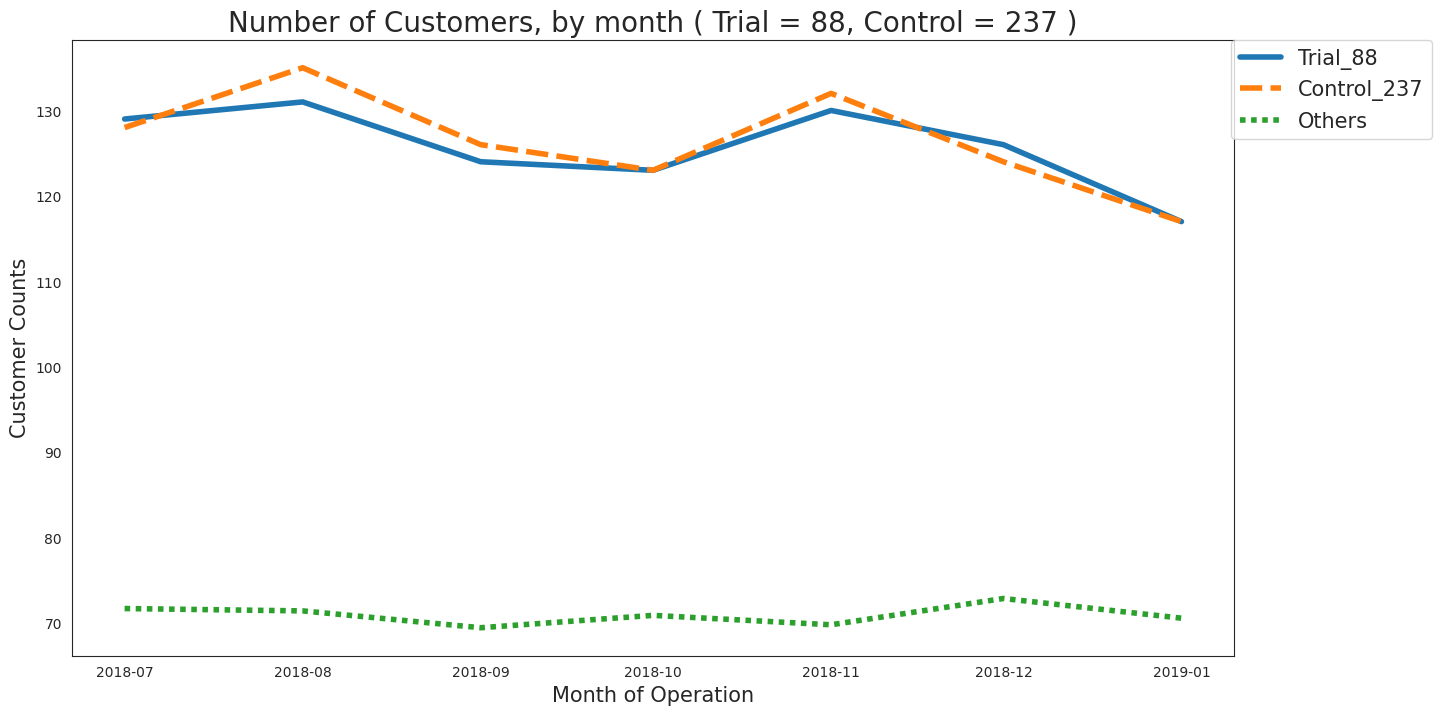

In [27]:
b = preTrialMeasures.set_index(["MONTH_ID","STORE_NBR"])["nCustomers"].unstack()
others_col = [i for i in b.columns if i not in [88, 237]]
b["others"]=b.loc[:,others_col].mean(axis=1)
paired_88_c = b.loc[:,([88,237,"others"])].reset_index()
paired_88_c["MONTH_ID"]= pd.to_datetime(paired_88_c["MONTH_ID"], format="%Y%m")
paired_88_c = paired_88_c.set_index(["MONTH_ID"])
paired_88_c.columns=["Trial_88","Control_237","Others"]

# Create a lineplot
plt.figure(figsize=(15,8))
plt.title("Number of Customers, by month ( Trial = 88, Control = 237 )",fontsize=20)
sns.lineplot(data=paired_88_c, linewidth=4)
plt.xlabel("Month of Operation",fontsize=15)
plt.ylabel("Customer Counts",fontsize=15)
plt.legend(fontsize=15, bbox_to_anchor=(1.17,1),borderaxespad = 0.)

2. Assessment of trial
1）Total sales

(1) Store 77

The trial period goes from the start of February 2019 to April 2019. We now want to see if there has been an uplift in overall chip sales. We'll start with scaling the control store's sales to a level similar to control for any differences between the two stores outside of the trial period.

In [28]:
# Scale pre-trial control sales to match pre-trial trial store sales
scalingControlSales_77 = (preTrialMeasures[preTrialMeasures["STORE_NBR"] == 77]["totSales"].sum()) / (preTrialMeasures[preTrialMeasures["STORE_NBR"] == 233]["totSales"].sum())
scalingControlSales_77

1.023617303289553

In [30]:
# Apply the scaling factor
scaledControlSales_77 = measure_over_time[measure_over_time["STORE_NBR"]== 233]
scaledControlSales_77["controlSales"] = scaledControlSales_77["totSales"] * scalingControlSales_77
scaledControlSales_77

<ipython-input-30-a9596ca1a227>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaledControlSales_77["controlSales"] = scaledControlSales_77["totSales"] * scalingControlSales_77


,STORE_NBR,MONTH_ID,totSales,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit,controlSales
2699,233,201807,290.7,51,1.058824,1.725490,3.303409,297.565550
2700,233,201808,285.9,48,1.041667,1.666667,3.573750,292.652187
2701,233,201809,228.6,42,1.071429,1.666667,3.265714,233.998916
2702,233,201810,185.7,35,1.028571,1.600000,3.316071,190.085733
2703,233,201811,211.6,40,1.025000,1.550000,3.412903,216.597421
2704,233,201812,279.8,47,1.063830,1.595745,3.730667,286.408121
2705,233,201901,177.5,35,1.000000,1.342857,3.776596,181.692071
2706,233,201902,244.0,45,1.044444,1.555556,3.485714,249.762622
2707,233,201903,199.1,40,1.025000,1.475000,3.374576,203.802205
2708,233,201904,158.6,30,1.066667,1.533333,3.447826,162.345704


In [31]:
trialSales_77 = measure_over_time[measure_over_time["STORE_NBR"]== 77].reset_index(drop=True)
scaledControlSales_77 = scaledControlSales_77.reset_index(drop=True)
percentageDiff_77_s = pd.concat([trialSales_77["MONTH_ID"],trialSales_77["totSales"],scaledControlSales_77["controlSales"]],axis=1)
percentageDiff_77_s.columns=["MONTH_ID","trialSales","controlSales"]
percentageDiff_77_s["percentageDiff"]= (abs(percentageDiff_77_s["trialSales"]-percentageDiff_77_s["controlSales"]))/percentageDiff_77_s["controlSales"]
percentageDiff_77_s

,MONTH_ID,trialSales,controlSales,percentageDiff
0,201807,296.8,297.565550,0.002573
1,201808,255.5,292.652187,0.126950
2,201809,225.2,233.998916,0.037602
3,201810,204.5,190.085733,0.075830
4,201811,245.3,216.597421,0.132516
5,201812,267.3,286.408121,0.066716
6,201901,204.4,181.692071,0.124980
7,201902,235.0,249.762622,0.059107
8,201903,278.5,203.802205,0.366521
9,201904,263.5,162.345704,0.623080


In [32]:
dof = 7

# standard deviation of percentage difference in pre-trail period
stdDev_77_s = percentageDiff_77_s[percentageDiff_77_s["MONTH_ID"]<201902]["percentageDiff"].std()
stdDev_77_s

0.04994076264142537

In [33]:
# Calculate the t-values for the trial months.
percentageDiff_77_s["tValue"] = (percentageDiff_77_s["percentageDiff"]-0)/stdDev_77_s
percentageDiff_77_s

,MONTH_ID,trialSales,controlSales,percentageDiff,tValue
0,201807,296.8,297.565550,0.002573,0.051515
1,201808,255.5,292.652187,0.126950,2.542011
2,201809,225.2,233.998916,0.037602,0.752940
3,201810,204.5,190.085733,0.075830,1.518406
4,201811,245.3,216.597421,0.132516,2.653459
5,201812,267.3,286.408121,0.066716,1.335911
6,201901,204.4,181.692071,0.124980,2.502571
7,201902,235.0,249.762622,0.059107,1.183534
8,201903,278.5,203.802205,0.366521,7.339116
9,201904,263.5,162.345704,0.623080,12.476373


In [34]:
# Critical value under 95% confidence & degree of freedom = 7
from scipy.stats import t
t.ppf(0.975,dof) # two-tail

2.3646242510102993

In [36]:
measureOverTimeSales_77 = measure_over_time
pastSales_77 = measureOverTimeSales_77
trial_store = 77
control_store = 233
store_type = []
for i in pastSales_77["STORE_NBR"]:
    if i == trial_store:
        store_type.append("Trial")
    elif i == control_store:
        store_type.append("Control")
    else:
        store_type.append("Other Stores")
pastSales_77["Store_type"] = store_type

# Create a new column 'TransactionMonth'
pastSales_77["TransactionMonth"] = pd.to_datetime(pastSales_77["MONTH_ID"], format = "%Y%m")

# select Trial and control store
pastSales_77 = pastSales_77.loc[pastSales_77["Store_type"].isin(["Control","Trial"])]
pastSales_77 = pastSales_77.loc[:,["TransactionMonth", "Store_type","totSales"]]
pastSales_77.head()

,TransactionMonth,Store_type,totSales
880,2018-07-01,Trial,296.8
881,2018-08-01,Trial,255.5
882,2018-09-01,Trial,225.2
883,2018-10-01,Trial,204.5
884,2018-11-01,Trial,245.3


In [37]:
pastSales_Controls95_77 = pastSales_77[pastSales_77["Store_type"] == "Control"]
pastSales_Controls95_77["totSales"] = pastSales_Controls95_77["totSales"] * (1+(stdDev_77_s*2))
pastSales_Controls95_77["Store_type"] = "Control 95th % confidence interval"
pastSales_Controls95_77 = pastSales_Controls95_77.loc[:,["TransactionMonth", "Store_type","totSales"]]
pastSales_Controls95_77.head()

<ipython-input-37-ea18642f278b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pastSales_Controls95_77["totSales"] = pastSales_Controls95_77["totSales"] * (1+(stdDev_77_s*2))
<ipython-input-37-ea18642f278b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pastSales_Controls95_77["Store_type"] = "Control 95th % confidence interval"


,TransactionMonth,Store_type,totSales
2699,2018-07-01,Control 95th % confidence interval,319.735559
2700,2018-08-01,Control 95th % confidence interval,314.456128
2701,2018-09-01,Control 95th % confidence interval,251.432917
2702,2018-10-01,Control 95th % confidence interval,204.247999
2703,2018-11-01,Control 95th % confidence interval,232.734931


In [38]:
# Control store 5th percentile
pastSales_Controls5_77 = pastSales_77[pastSales_77["Store_type"] == "Control"]
pastSales_Controls5_77["totSales"] = pastSales_Controls95_77["totSales"] * (1-(stdDev_77_s*2))
pastSales_Controls5_77["Store_type"] = "Control 5th % confidence interval"
pastSales_Controls5_77 = pastSales_Controls5_77.loc[:,["TransactionMonth", "Store_type","totSales"]]
pastSales_Controls5_77.head()

<ipython-input-38-d0273a508d10>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pastSales_Controls5_77["totSales"] = pastSales_Controls95_77["totSales"] * (1-(stdDev_77_s*2))
<ipython-input-38-d0273a508d10>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pastSales_Controls5_77["Store_type"] = "Control 5th % confidence interval"


,TransactionMonth,Store_type,totSales
2699,2018-07-01,Control 5th % confidence interval,287.799884
2700,2018-08-01,Control 5th % confidence interval,283.047770
2701,2018-09-01,Control 5th % confidence interval,226.319413
2702,2018-10-01,Control 5th % confidence interval,183.847398
2703,2018-11-01,Control 5th % confidence interval,209.489011


In [40]:
# Merge 3 tables above together
trialAssessment_77_s = pd.concat([pastSales_77, pastSales_Controls95_77, pastSales_Controls5_77])
trialAssessment_77_s.head()

,TransactionMonth,Store_type,totSales
880,2018-07-01,Trial,296.8
881,2018-08-01,Trial,255.5
882,2018-09-01,Trial,225.2
883,2018-10-01,Trial,204.5
884,2018-11-01,Trial,245.3


In [41]:
# Plotting these in one nice graph
# Dataset for barplot
bar_77_s = trialAssessment_77_s
bar_77_s["TransactionMonth"] = bar_77_s["TransactionMonth"].dt.strftime("%Y-%m").astype("str")
bar_77_s = bar_77_s.set_index("TransactionMonth")
bar_77_s = bar_77_s.iloc[:24,:]
bar_77_s.head()

,Store_type,totSales
TransactionMonth,,
2018-07,Trial,296.8
2018-08,Trial,255.5
2018-09,Trial,225.2
2018-10,Trial,204.5
2018-11,Trial,245.3


In [42]:
line_77_s = trialAssessment_77_s.set_index(["TransactionMonth","Store_type"])["totSales"].unstack()
line_77_s = line_77_s.iloc[:,[1,2]]
line_77_s.head()

Store_type,Control 5th % confidence interval,Control 95th % confidence interval
TransactionMonth,,
2018-07,287.799884,319.735559
2018-08,283.047770,314.456128
2018-09,226.319413,251.432917
2018-10,183.847398,204.247999
2018-11,209.489011,232.734931


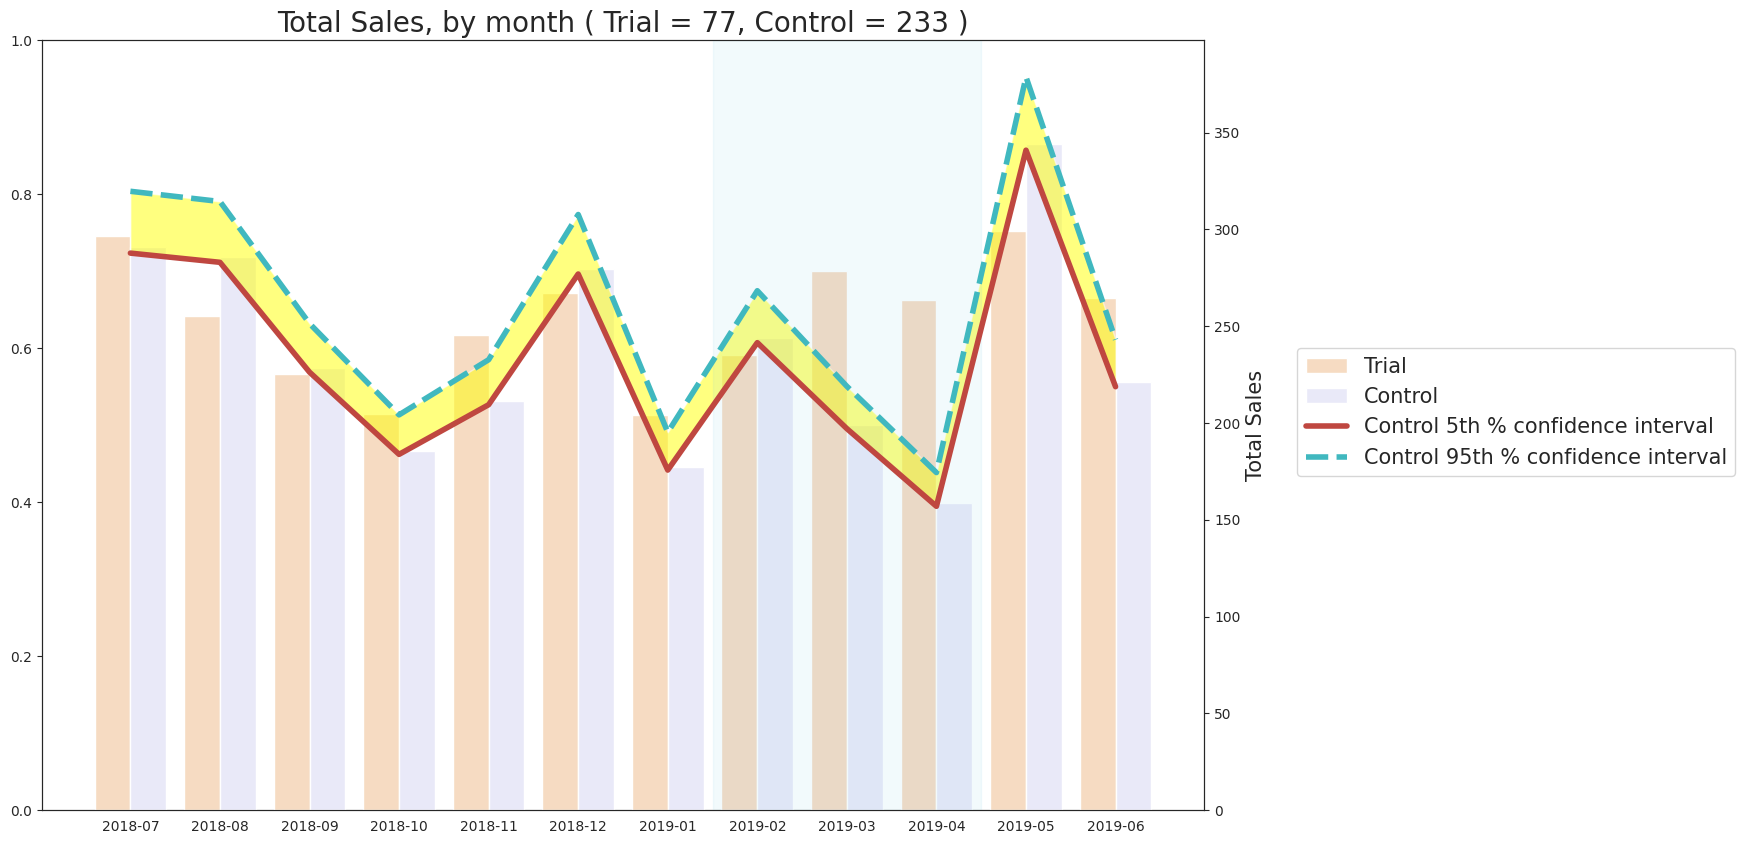

In [43]:
# Plotting
fig, ax1 = plt.subplots(1, 1, figsize=(15,10))
ax2 = ax1.twinx()
ax1 = sns.barplot(x=bar_77_s.index, y=bar_77_s["totSales"], hue=bar_77_s["Store_type"], data=bar_77_s,
                 palette=["peachpuff","lavender"])
ax2 = sns.lineplot(data=line_77_s, linewidth=4, palette=sns.hls_palette(2, l=.5, s=.5))
# Yellow shadow to show values between 5% and 95% confidence
ax2.fill_between(line_77_s.index,
                 line_77_s["Control 5th % confidence interval"], line_77_s["Control 95th % confidence interval"],
                 facecolor="yellow", alpha=0.5)
# blue shadow to show trial period
plt.axvspan(xmin=6.5, xmax=9.5, color = 'skyblue', alpha = 0.1)
plt.title("Total Sales, by month ( Trial = 77, Control = 233 )",fontsize=20)
plt.xlabel("Month of Operation",fontsize=15)
plt.ylabel("Total Sales", fontsize=15)
plt.legend(fontsize=15, bbox_to_anchor=(1.08,0.6),borderaxespad = 0.)

(2) Store 86

In [48]:
scalingControlSales_86 = (preTrialMeasures[preTrialMeasures["STORE_NBR"] == 86]["totSales"].sum()) / (preTrialMeasures[preTrialMeasures["STORE_NBR"] == 155]["totSales"].sum())
#scalingControlSales_86

# Apply the scaling factor
scaledControlSales_86 = measure_over_time[measure_over_time["STORE_NBR"]== 155]
scaledControlSales_86["controlSales"] = scaledControlSales_86["totSales"] * scalingControlSales_86

<ipython-input-48-d26530ccfafe>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaledControlSales_86["controlSales"] = scaledControlSales_86["totSales"] * scalingControlSales_86


In [47]:
# Calculate the percentage difference between scaled control sales and trial sales
trialSales_86 = measure_over_time[measure_over_time["STORE_NBR"]== 86].reset_index(drop=True)
scaledControlSales_86 = scaledControlSales_86.reset_index(drop=True)
percentageDiff_86_s = pd.concat([trialSales_86["MONTH_ID"],trialSales_86["totSales"],scaledControlSales_86["controlSales"]],axis=1)
percentageDiff_86_s.columns=["MONTH_ID","trialSales","controlSales"]
percentageDiff_86_s["percentageDiff"]= (abs(percentageDiff_86_s["trialSales"]-percentageDiff_86_s["controlSales"]))/percentageDiff_86_s["controlSales"]

In [49]:
dof = 7
# standard deviation of percentage difference in pre-trail period
stdDev_86_s = percentageDiff_86_s[percentageDiff_86_s["MONTH_ID"]<201902]["percentageDiff"].std()
stdDev_86_s

0.025833952854772368

In [51]:
# Calculate the t-values for the trial months.
percentageDiff_86_s["tValue"] = (percentageDiff_86_s["percentageDiff"]-0)/stdDev_86_s
percentageDiff_86_s.head()

,MONTH_ID,trialSales,controlSales,percentageDiff,tValue
0,201807,892.20,896.922236,0.005265,0.203799
1,201808,764.05,759.269991,0.006296,0.243692
2,201809,914.60,984.034086,0.070561,2.731315
3,201810,948.40,934.948790,0.014387,0.556907
4,201811,918.00,871.894555,0.052880,2.046904


In [53]:
measureOverTimeSales_86 = measure_over_time
pastSales_86 = measureOverTimeSales_86
trial_store = 86
control_store = 155
store_type = []
for i in pastSales_86["STORE_NBR"]:
    if i == trial_store:
        store_type.append("Trial")
    elif i == control_store:
        store_type.append("Control")
    else:
        store_type.append("Other Stores")
pastSales_86["Store_type"] = store_type

# Create a new column 'TransactionMonth'
pastSales_86["TransactionMonth"] = pd.to_datetime(pastSales_86["MONTH_ID"], format = "%Y%m")

# select Trial and control store
pastSales_86 = pastSales_86.loc[pastSales_86["Store_type"].isin(["Control","Trial"])]
pastSales_86 = pastSales_86.loc[:,["TransactionMonth", "Store_type","totSales"]]

In [54]:
pastSales_Controls95_86 = pastSales_86[pastSales_86["Store_type"] == "Control"]
pastSales_Controls95_86["totSales"] = pastSales_Controls95_86["totSales"] * (1+(stdDev_86_s*2))
pastSales_Controls95_86["Store_type"] = "Control 95th % confidence interval"
pastSales_Controls95_86 = pastSales_Controls95_86.loc[:,["TransactionMonth", "Store_type","totSales"]]

<ipython-input-54-beb728988338>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pastSales_Controls95_86["totSales"] = pastSales_Controls95_86["totSales"] * (1+(stdDev_86_s*2))
<ipython-input-54-beb728988338>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pastSales_Controls95_86["Store_type"] = "Control 95th % confidence interval"


In [55]:
pastSales_Controls5_86 = pastSales_86[pastSales_86["Store_type"] == "Control"]
pastSales_Controls5_86["totSales"] = pastSales_Controls95_86["totSales"] * (1-(stdDev_86_s*2))
pastSales_Controls5_86["Store_type"] = "Control 5th % confidence interval"
pastSales_Controls5_86 = pastSales_Controls5_86.loc[:,["TransactionMonth", "Store_type","totSales"]]

<ipython-input-55-b644a614a23d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pastSales_Controls5_86["totSales"] = pastSales_Controls95_86["totSales"] * (1-(stdDev_86_s*2))
<ipython-input-55-b644a614a23d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pastSales_Controls5_86["Store_type"] = "Control 5th % confidence interval"


In [56]:
trialAssessment_86_s = pd.concat([pastSales_86, pastSales_Controls95_86, pastSales_Controls5_86])

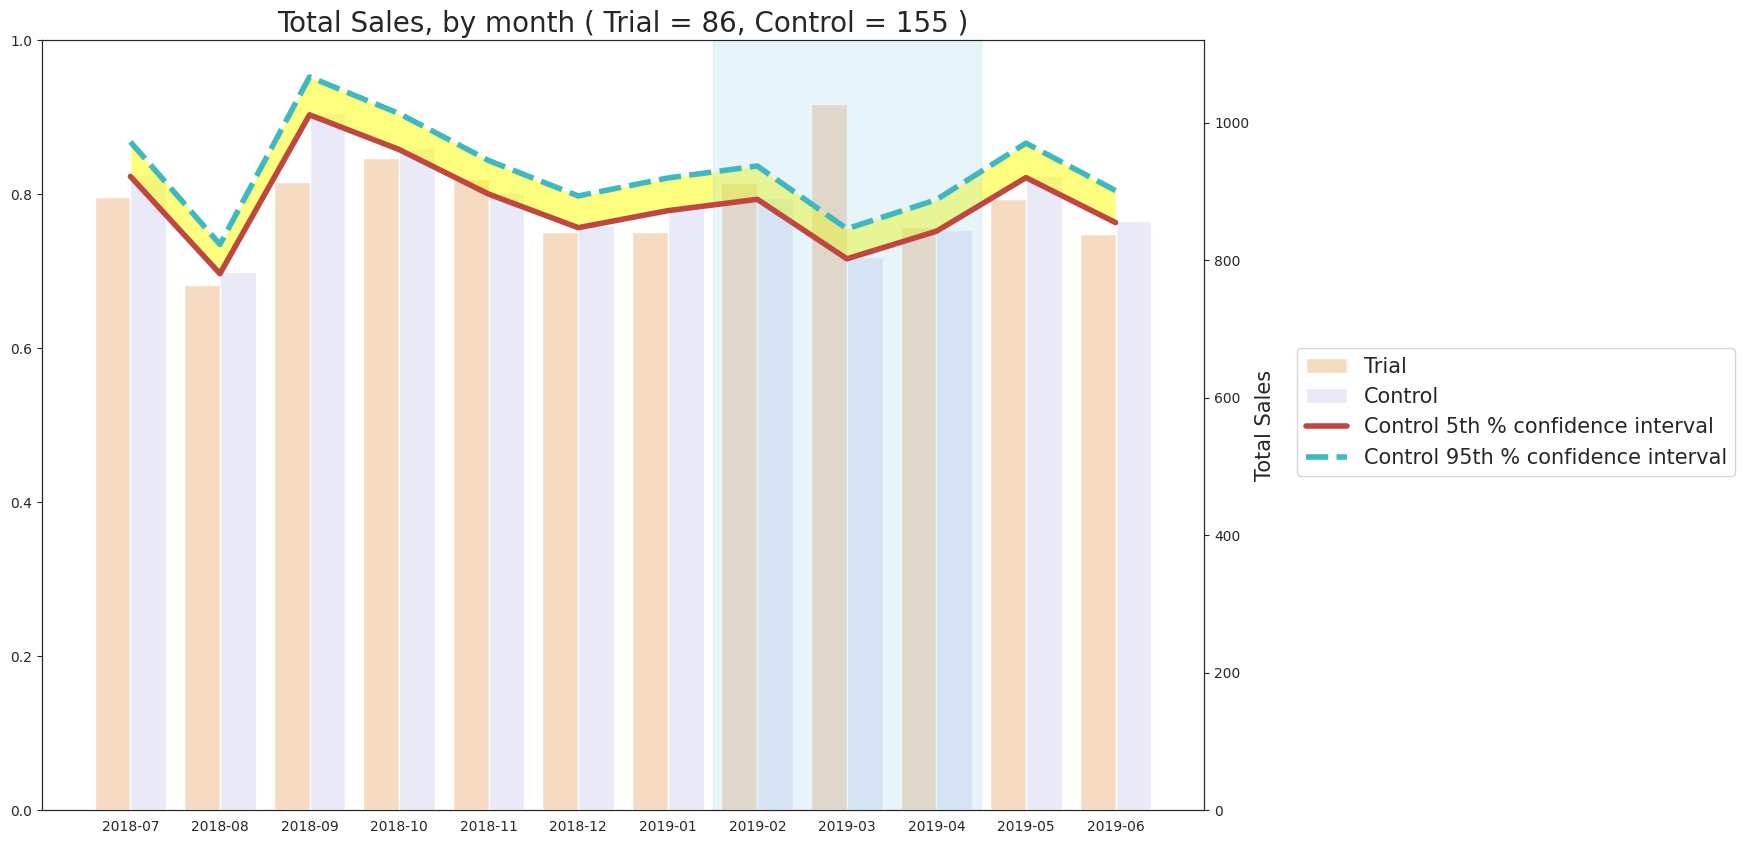

In [57]:
bar_86_s = trialAssessment_86_s
bar_86_s["TransactionMonth"] = bar_86_s["TransactionMonth"].dt.strftime("%Y-%m").astype("str")
bar_86_s = bar_86_s.set_index("TransactionMonth")
bar_86_s = bar_86_s.iloc[:24,:]
#bar_86_s

# Dataset for lineplot
line_86_s = trialAssessment_86_s.set_index(["TransactionMonth","Store_type"])["totSales"].unstack()
line_86_s = line_86_s.iloc[:,[1,2]]
line_86_s

# Plotting
fig, ax1 = plt.subplots(1, 1, figsize=(15,10))
ax2 = ax1.twinx()
ax1 = sns.barplot(x=bar_86_s.index, y=bar_86_s["totSales"], hue=bar_86_s["Store_type"], data=bar_86_s,
                 palette=["peachpuff","lavender"])
ax2 = sns.lineplot(data=line_86_s, linewidth=4, palette=sns.hls_palette(2, l=.5, s=.5))
# Yellow shadow to show values between 5% and 95% confidence
ax2.fill_between(line_86_s.index,
                 line_86_s["Control 5th % confidence interval"], line_86_s["Control 95th % confidence interval"],
                 facecolor="yellow", alpha=0.5)
# blue shadow to show trial period
plt.axvspan(xmin=6.5, xmax=9.5, color = 'skyblue', alpha = 0.2)
plt.title("Total Sales, by month ( Trial = 86, Control = 155 )",fontsize=20)
plt.xlabel("Month of Operation",fontsize=15)
plt.ylabel("Total Sales", fontsize=15)
plt.legend(fontsize=15, bbox_to_anchor=(1.08,0.6),borderaxespad = 0.)